# Import Dataset and Libraries

In [87]:
# Standarc library imports
from collections import defaultdict
from random import randrange
from tqdm import tqdm
from typing import Any
import warnings

# Third-party imports
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif_func

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, hamming_loss, jaccard_score,
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OneHotEncoder, OrdinalEncoder, StandardScaler

DO_OPTIMIZATION = False
RANDOM_STATE = 42
TEST_SIZE = 0.2
ROYALBLUE = "#4169E1"

In [88]:
warnings.filterwarnings(action='ignore')    # 주피터 노트북 에러 로그 무시하는 코드
plt.rc('font', family='Malgun Gothic')      # plt로 한글 폰트 사용하는 코드
pd.set_option('display.max_columns', None)  # 데이터프레임의 모든 열을 출력하는 코드

In [89]:
STD_PATH = "."
TRAIN_FILE = f"{STD_PATH}/train.csv"
TEST_FILE = f"{STD_PATH}/test.csv"

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

is_pregnant = df_train.columns[-1]
X, y = df_train.drop(is_pregnant, axis=1), df_train[is_pregnant]
X_test = df_test.drop(is_pregnant, axis=1) if is_pregnant in df_test else df_test.copy()

# EDA

In [90]:
def draw_imbalance_barplot(df: pd.DataFrame, title: str, width: int=10, height: int=2) -> None:
    df[title].value_counts().plot.bar(
        color='royalblue',
        figsize = (width, height),
    )    
    plt.title(title)
    plt.xlabel(f"{title} 컬럼의 데이터 종류")
    plt.ylabel('데이터 개수')
    plt.grid(True, linestyle='--', linewidth=0.3, axis='y')
    return

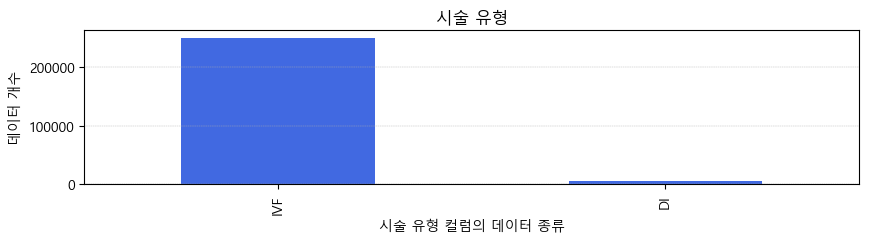

In [91]:
# 테스트용 그래프 그리기(무작위 컬럼)
random_column = X.columns.tolist()[randrange(1, len(X.columns.tolist()))]
draw_imbalance_barplot(X, random_column)

In [92]:
def draw_heatmap(df: pd.DataFrame, method: str='pearson', width: int=8, height: int=8) -> None:
    # method: pearson(default), kendall, spearman
    # interpolation: None(default), nearest, bilinear, bicubic, gaussian, hanning, hamming, lanczos, none
    
    corr_matrix = df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))    
    plt.figure(figsize=(width, height))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
    return

In [93]:
# # 테스트용 그래프 그리기
# draw_heatmap(X, width=50, height=50)

In [94]:
# 범주형 변수이되, 범주 정보가 0: False, 1: True인 column들
categorical_int64_columns = [
    '단일 배아 이식 여부',
    '착상 전 유전 검사 사용 여부',
    '착상 전 유전 진단 사용 여부',
    '동결 배아 사용 여부',
    '신선 배아 사용 여부',
    '기증 배아 사용 여부',
    '대리모 여부',
    'PGD 시술 여부',
    'PGS 시술 여부',
    '배란 자극 여부',
    '남성 주 불임 원인',
    '남성 부 불임 원인',
    '여성 주 불임 원인',
    '여성 부 불임 원인',
    '부부 주 불임 원인',
    '부부 부 불임 원인',
    '불명확 불임 원인',
    '불임 원인 - 난관 질환',
    '불임 원인 - 남성 요인',
    '불임 원인 - 배란 장애',
    '불임 원인 - 여성 요인',
    '불임 원인 - 자궁경부 문제',
    '불임 원인 - 자궁내막증',
    '불임 원인 - 정자 농도',
    '불임 원인 - 정자 면역학적 요인',
    '불임 원인 - 정자 운동성',
    '불임 원인 - 정자 형태'    
]

In [95]:
float64_columns = list(set(X.select_dtypes(include='float64').columns.tolist()) - set(categorical_int64_columns))
# int64_columns = X.select_dtypes(include='int64').columns.tolist()
object_columns = X.select_dtypes(include='O').columns.tolist()

# Data Preprocessing

### 1. Feature Cleaning

In [96]:
# """
# - Missing values(drop, mean, median, mode, KNNImputer, MICE)
# - Outliers (IQR, log)
# - Feature selection(remove duplicates, VIF)
# """

In [97]:
values = {
    **{column: 0 for column in float64_columns},
    **{column: 0 for column in categorical_int64_columns},
    # **{column: "0" for column in object_columns}
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

#### Feature Cleaning - 시술 시기코드(1) 

In [98]:
# 시기 코드는 ID처럼 구분을 위한 컬럼이라고 판단, drop하기로 결정

#### Feature Cleaning - 배란 유도 유형(7)

In [99]:
# X['배란 유도 유형'].value_counts().tolist()
# X_test['배란 유도 유형'].value_counts().tolist()
# value_counts() 결과, train과 test를 통틀어서 유의미한 데이터는 단 2건, 따라서 drop하기로 결정

### 2. Feature Engineering

In [100]:
# """
# - Feature Creation
# - Feature Transformation(log, sqrt, min-max scaling)
# - Feature Extraction(PCA, LDA, heatmap)
# """

#### Feature Engineering - 임신 시도 또는 마지막 임신 경과 연수(3)

In [101]:
# float64 컬럼

#### Feature Engineering - 총 시술 횟수(29) ~ DI 출산 횟수(38)

In [102]:
# 이진 분류기의 최종 목표는 '임신 성공 여부'이기에, 출산 횟수는 전부 drop한다.
# 또한 IVF와 DI의 차이보다는 총 횟수에 중점을 두어 계산한다. (plot().bar()로 분포 차이를 보았을 때 무의미하다 판단)
# 따라서 최종 사용하는 컬럼은 '총 시술 횟수'와 '총 임신 횟수' 2개다.
# 이떄 '총 임신 횟수' / '총 시술 횟수'로 '시술 대비 임신 성공률' 컬럼을 파생 변수로 사용한다.

# 주의할 점은 np.nan와 0의 차이이다.
# 총 시술 횟수가 0인 경우, 0으로 나눌 수 없기에(시술 횟수 자체가 0이기에) np.nan이 나온다.
# 하지만 총 임신 횟수만 0인 경우(시술은 했지만 임신하지 못 한 경우), NaN이 아니라 0이 나온다.
# 둘 다 '실패'로 간주하여 0으로 처리한다. 더 나은 방법이 있다면 차후 변경
def get_int(data: str) -> int:
    return int(data[0])

X['총 임신 횟수'] = X['총 임신 횟수'].map(get_int)
X['총 시술 횟수'] = X['총 시술 횟수'].map(get_int)
X_pregnancy = rate = X['총 임신 횟수'] / X['총 시술 횟수']
X['시술 대비 임신 성공률'] = X_pregnancy.fillna(0.0)

X_test['총 임신 횟수'] = X_test['총 임신 횟수'].map(get_int)
X_test['총 시술 횟수'] = X_test['총 시술 횟수'].map(get_int)
X_test_pregnancy = rate = X_test['총 임신 횟수'] / X_test['총 시술 횟수']
X_test['시술 대비 임신 성공률'] = X_test_pregnancy.fillna(0.0)

#### Feature Engineering - 총 생성 배아 수(39) ~ 기증자 정자와 혼합된 난자 수(52) 

In [103]:
# float64 컬럼

#### Feature Engineering - 난자 채취 경과일(63) ~ 배아 해동 경과일(67)

In [104]:
# float64 컬럼

### 3. Feature Encoding

In [105]:
# """
# - LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
# """

#### Feature Encoding - Categorical int64 columns

In [106]:
# 배란 자극 여부(6), 단일 배아 이식 여부(8) ~ 불임 원인 - 정자 형태(27), 동결 배아 사용 여부(57) ~ PGS 시술 여부(62)

In [107]:
# 범주 정보가 0: False, 1: True인 column들 bool으로 타입 변환
for column_name in categorical_int64_columns:
    X[column_name] = X[column_name].astype(bool)
    X_test[column_name] = X_test[column_name].astype(bool)

#### Feature Encoding - 시술 당시 나이(2)

In [108]:
# '알 수 없음' 데이터는 최빈값으로 처리
X['시술 당시 나이'] = X['시술 당시 나이'].replace('알 수 없음', np.nan)
X['시술 당시 나이'].fillna(X['시술 당시 나이'].mode()[0], inplace=True)
X_test['시술 당시 나이'] = X_test['시술 당시 나이'].replace('알 수 없음', np.nan)
X_test['시술 당시 나이'].fillna(X_test['시술 당시 나이'].mode()[0], inplace=True)

# OrdinalEncoder 사용을 위해 나이 순서대로 order 준비
custom_order = [sorted(X['시술 당시 나이'].value_counts().index.tolist())]
encoder = OrdinalEncoder(categories=custom_order)

# 나이(순서)를 반영하여 encoding 진행
X['시술 당시 나이'] = encoder.fit_transform(X[['시술 당시 나이']])
X_test['시술 당시 나이'] = encoder.fit_transform(X_test[['시술 당시 나이']])

#### Feature Encoding - 시술 유형(4)

In [109]:
# 시술 유형은 2가지(IVF와 DI)로 VIF 추론이 가능하므로 drop_first함
encoder = OneHotEncoder(drop='first', sparse_output=False)

# 2가지 데이터에 대해 처리했으므로 True와 False로 취급할 수 있다고 판단하였다.
# 따라서, 메모리 개선을 위해 ohe로 transform한 값을 bool로 바꿔주었다.
X['시술 유형'] = encoder.fit_transform(X[['시술 유형']]).astype(int).astype(bool)
X_test['시술 유형'] = encoder.fit_transform(X_test[['시술 유형']]).astype(int).astype(bool)

#### Feature Encoding - 특정 시술 유형(5)

In [110]:
# Feature Cleaning
X['특정 시술 유형'].fillna('0', inplace=True)
X_test['특정 시술 유형'].fillna('0', inplace=True)

# 복합 요소 떄문에 Multi-Label 인코딩을 진행
mlb = MultiLabelBinarizer()

# 정규화를 위한 정규표현식 dictionary
replace_dict = {':': '/', ' ': '', '0': 'Unknown'}

# 데이터 정규화
X['특정 시술 유형'] = X['특정 시술 유형'].replace(replace_dict, regex=True).str.split('/')
X_test['특정 시술 유형'] = X_test['특정 시술 유형'].replace(replace_dict, regex=True).str.split('/')

# Multi-Label Encoding 진행 후 데이터프레임 병합
X_encoded = mlb.fit_transform(X['특정 시술 유형'])
X = pd.concat([X, pd.DataFrame(X_encoded, columns=mlb.classes_)], axis=1)
X_test_encoded = mlb.fit_transform(X_test['특정 시술 유형'])
X_test = pd.concat([X_test, pd.DataFrame(X_test_encoded, columns=mlb.classes_)], axis=1)

In [111]:
# 데이터 drop에 사용할 column 이름 변수
시술_유형_mlb_columns = mlb.classes_.tolist()

#### Feature Encoding - 배아 생성 주요 이유(28)

In [112]:
# Feature Cleaning
X['배아 생성 주요 이유'].fillna('', inplace=True)
X_test['배아 생성 주요 이유'].fillna('', inplace=True)

# 복합 요소 떄문에 Multi-Label 인코딩을 진행
mlb = MultiLabelBinarizer()

# 정규화를 위한 정규표현식 dictionary
replace_dict = {' ': ''}

# 데이터 정규화
X['배아 생성 주요 이유'] = X['배아 생성 주요 이유'].replace(replace_dict, regex=True).str.split(',')
X_test['배아 생성 주요 이유'] = X_test['배아 생성 주요 이유'].replace(replace_dict, regex=True).str.split(',')

# Multi-Label Encoding 진행 후 데이터프레임 병합
X_encoded = pd.DataFrame(mlb.fit_transform(X['배아 생성 주요 이유']), columns=mlb.classes_).drop([""], axis=1)
X = pd.concat([X, X_encoded], axis=1)
X_test_encoded = pd.DataFrame(mlb.fit_transform(X_test['배아 생성 주요 이유']), columns=mlb.classes_).drop([""], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

In [113]:
# 데이터 drop에 사용할 column 이름 변수
배아_생성_주요_이유_mlb_columns = mlb.classes_[1:]

#### Feature Encoding - 난자 출처(53)

In [114]:
# 난자 출처는 3가지 값(본인 제공, 기증 제공, 알 수 없음)만을 가지고 있다.
# 순서가 존재하는 것도 아니고 column이 극단적으로 늘어나는 경우도 아니기에 OneHotEncoding(get_dummies)을 진행
# 본인 제공 0, 기증 제공 0인 경우에는 자연스럽게 알 수 없는 경우가 된다.
# 따라서 '알 수 없음' column을 제거하면, VIF를 없앨 수 있다.
X_난자_출처 = pd.get_dummies(X, columns=['난자 출처'])[['난자 출처_본인 제공', '난자 출처_기증 제공']]
X = pd.concat([X, X_난자_출처], axis=1)
X_test_난자_출처 = pd.get_dummies(X_test, columns=['난자 출처'])[['난자 출처_본인 제공', '난자 출처_기증 제공']]
X_test = pd.concat([X_test, X_test_난자_출처], axis=1)

#### Feature Encoding - 정자 출처(54)

In [115]:
# 난자 출처는 4가지 값(배우자 제공, 기증 제공, 미할당, 배우자 및 기증 제공)을 가지고 있다.
# '배우자 제공'과 '기증 제공'을 기준으로 Multi-Label Encoding 진행.
mlb = MultiLabelBinarizer()


# 정규화를 위한 func
def replace_semen_source(data: str) -> list:
    if '및' in data:
        return ['정자 출처_배우자 제공', '정자 출처_기증 제공']
    elif '배우자' in data:
        return ['정자 출처_배우자 제공']
    elif '기증' in data:
        return ['정자 출처_기증 제공']
    else:
        return []


# 데이터 정규화
X['정자 출처'] = X['정자 출처'].map(replace_semen_source)
X_test['정자 출처'] = X_test['정자 출처'].map(replace_semen_source)

# Multi-Label Encoding 진행 후 데이터프레임 병합
X_encoded = mlb.fit_transform(X['정자 출처'])
X = pd.concat([X, pd.DataFrame(X_encoded, columns=mlb.classes_).astype(bool)], axis=1)
X_test_encoded = mlb.fit_transform(X_test['정자 출처'])
X_test = pd.concat([X_test, pd.DataFrame(X_test_encoded, columns=mlb.classes_).astype(bool)], axis=1)

In [116]:
# 데이터 drop에 사용할 column 이름 변수
정자_출처_mlb_columns = mlb.classes_.tolist()

#### Feature Encoding - 난자 기증자 나이(55), 정자 기증자 나이(56)

In [117]:
# OrdinalEncodeing 방식을 위해 나이 순서대로 order 준비
custom_order = ['알 수 없음', '만20세 이하', '만21-25세', '만26-30세', '만31-35세', '만36-40세', '만41-45세']

# 나이(순서)를 반영하여 encoding 진행
X['난자 기증자 나이'] = X['난자 기증자 나이'].apply(lambda x: custom_order.index(x))
X['정자 기증자 나이'] = X['정자 기증자 나이'].apply(lambda x: custom_order.index(x))
X_test['난자 기증자 나이'] = X_test['난자 기증자 나이'].apply(lambda x: custom_order.index(x))
X_test['정자 기증자 나이'] = X_test['정자 기증자 나이'].apply(lambda x: custom_order.index(x))

### 4. Feature Removal

In [118]:
# VIF 계산하는 함수 개선 필요
def calculate_vif(df: pd.DataFrame):
    df_numeric = df.select_dtypes(include=["number"])
    # df_categorical = df.select_dtypes(include=["object"])
    # df_encoded = pd.get_dummies(df_categorical, drop_first=True)
    # df_final = pd.concat([df_numeric, df_encoded], axis=1)
    df = df_numeric.fillna(df_numeric.mean())
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [vif_func(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

In [119]:
# VIF 계산
vif_result = calculate_vif(X)

In [120]:
drop_features = [
    vif_result.iloc[idx][0]
    for idx in range(len(vif_result))
    if vif_result.iloc[idx][1] >= 10
]

In [121]:
# 주석이 달린 컬럼만 모델 학습에 사용
drop_features = [
     'ID',
     '시술 시기 코드',
    #  '시술 당시 나이',
    #  '임신 시도 또는 마지막 임신 경과 연수',
    #  '시술 유형',
     '특정 시술 유형',
    #  '배란 자극 여부',
     '배란 유도 유형',
    #  '단일 배아 이식 여부',
    #  '착상 전 유전 검사 사용 여부',
    #  '착상 전 유전 진단 사용 여부',
    #  '남성 주 불임 원인',
    #  '남성 부 불임 원인',
    #  '여성 주 불임 원인',
    #  '여성 부 불임 원인',
    #  '부부 주 불임 원인',
    #  '부부 부 불임 원인',
    #  '불명확 불임 원인',
    #  '불임 원인 - 난관 질환',
    #  '불임 원인 - 남성 요인',
    #  '불임 원인 - 배란 장애',
    #  '불임 원인 - 여성 요인',
    #  '불임 원인 - 자궁경부 문제',
    #  '불임 원인 - 자궁내막증',
    #  '불임 원인 - 정자 농도',
    #  '불임 원인 - 정자 면역학적 요인',
    #  '불임 원인 - 정자 운동성',
    #  '불임 원인 - 정자 형태',
     '배아 생성 주요 이유',
    #  '총 시술 횟수',
     '클리닉 내 총 시술 횟수',
     'IVF 시술 횟수',
     'DI 시술 횟수',
    #  '총 임신 횟수',
     'IVF 임신 횟수',
     'DI 임신 횟수',
     '총 출산 횟수',
     'IVF 출산 횟수',
     'DI 출산 횟수',
    #  '총 생성 배아 수',
    #  '미세주입된 난자 수',
    #  '미세주입에서 생성된 배아 수',
    #  '이식된 배아 수',
    #  '미세주입 배아 이식 수',
    #  '저장된 배아 수',
    #  '미세주입 후 저장된 배아 수',
    #  '해동된 배아 수',
    #  '해동 난자 수',
    #  '수집된 신선 난자 수',
    #  '저장된 신선 난자 수',
    #  '혼합된 난자 수',
    #  '파트너 정자와 혼합된 난자 수',
    #  '기증자 정자와 혼합된 난자 수',
     '난자 출처',
     '정자 출처',
    #  '난자 기증자 나이',
    #  '정자 기증자 나이',
    #  '동결 배아 사용 여부',
    #  '신선 배아 사용 여부',
    #  '기증 배아 사용 여부',
    #  '대리모 여부',
    #  'PGD 시술 여부',
    #  'PGS 시술 여부',
    #  '난자 채취 경과일',
    #  '난자 해동 경과일',
    #  '난자 혼합 경과일',
    #  '배아 이식 경과일',
    #  '배아 해동 경과일',
    # '시술 대비 임신 성공률',
    # *시술_유형_mlb_columns,
    # *배아_생성_주요_이유_mlb_columns,
    # '난자 출처_기증 제공',
    # '난자 출처_본인 제공',
    # *정자_출처_mlb_columns,
]

In [122]:
drop_features

['ID',
 '시술 시기 코드',
 '특정 시술 유형',
 '배란 유도 유형',
 '배아 생성 주요 이유',
 '클리닉 내 총 시술 횟수',
 'IVF 시술 횟수',
 'DI 시술 횟수',
 'IVF 임신 횟수',
 'DI 임신 횟수',
 '총 출산 횟수',
 'IVF 출산 횟수',
 'DI 출산 횟수',
 '난자 출처',
 '정자 출처']

In [123]:
X = X.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

# Hyperparameter Tuning

In [125]:
# https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C

In [126]:
def optimize() -> None:
    return


if DO_OPTIMIZATION:
    optimize()

# Modeling

### 1. Import

In [127]:
# Model imports
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [128]:
clf_model_dict = {
    "adaboost": AdaBoostClassifier(),
    "gradient": GradientBoostingClassifier(),
    "random_forest": RandomForestClassifier(),
    "lasso": LogisticRegression(penalty='l1', solver='liblinear'),
    "ridge": LogisticRegression(penalty='l2', solver='lbfgs'),
    "svc": SVC(probability=True),
    "decision_tree": DecisionTreeClassifier(),
    "catboost": CatBoostClassifier(verbose=False),
    "lgbm": LGBMClassifier(),
    "xgb": XGBClassifier(),
}

### 2. Training

In [129]:
def eval(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    # is CatBoostClassifier
    if isinstance(y_pred[0], str):
        accuracy = accuracy_score(y, y_pred)                        # 정확도
        precision = precision_score(y, y_pred, pos_label='True')    # 정밀도
        recall = recall_score(y, y_pred, pos_label='True')          # 재현율
        f1 = f1_score(y, y_pred, pos_label='True')                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)                         # ROC-AUC 점수
        
    else:
        accuracy = accuracy_score(y, y_pred)      # 정확도
        precision = precision_score(y, y_pred)    # 정밀도
        recall = recall_score(y, y_pred)          # 재현율
        f1 = f1_score(y, y_pred)                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

### 3. Select Model

In [138]:
model_name = "xgb"
model = clf_model_dict[model_name]

### 4. K-Fold Cross Validation

In [139]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = []
score_types = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[test_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    scores = eval(model, X_val, y_val)
    roc_auc_scores.append(scores[-1])

    for score_type, score in zip(score_types, scores):
        print(f"{score_type} (Fold {idx}): {score}")
    print()

print(f"Cross-Validation Average ROC-AUC Score: {np.mean(roc_auc_scores)}")

Accuracy (Fold 0): 0.7439488209709192
Precision (Fold 0): 0.5173938679245284
Recall (Fold 0): 0.13249282802355428
F1-Score (Fold 0): 0.2109628561125135
ROC-AUC (Fold 0): 0.7333234609770922

Accuracy (Fold 1): 0.744392432221572
Precision (Fold 1): 0.5212249848392966
Recall (Fold 1): 0.12978482446206116
F1-Score (Fold 1): 0.20782203953333736
ROC-AUC (Fold 1): 0.7380163256128061

Accuracy (Fold 2): 0.744802028476692
Precision (Fold 2): 0.523462547362285
Recall (Fold 2): 0.1355983389958475
F1-Score (Fold 2): 0.21539937634924444
ROC-AUC (Fold 2): 0.7355380113170862

Accuracy (Fold 3): 0.7432416617905208
Precision (Fold 3): 0.5118702953097858
Recall (Fold 3): 0.1334742563792843
F1-Score (Fold 3): 0.21173652694610778
ROC-AUC (Fold 3): 0.7332155523475736

Accuracy (Fold 4): 0.7434757167934465
Precision (Fold 4): 0.5140550239234449
Recall (Fold 4): 0.12977502642307112
F1-Score (Fold 4): 0.20723327305605788
ROC-AUC (Fold 4): 0.7356200460613271

Cross-Validation Average ROC-AUC Score: 0.735142679

# Visualization

### 1. Using Seaborn

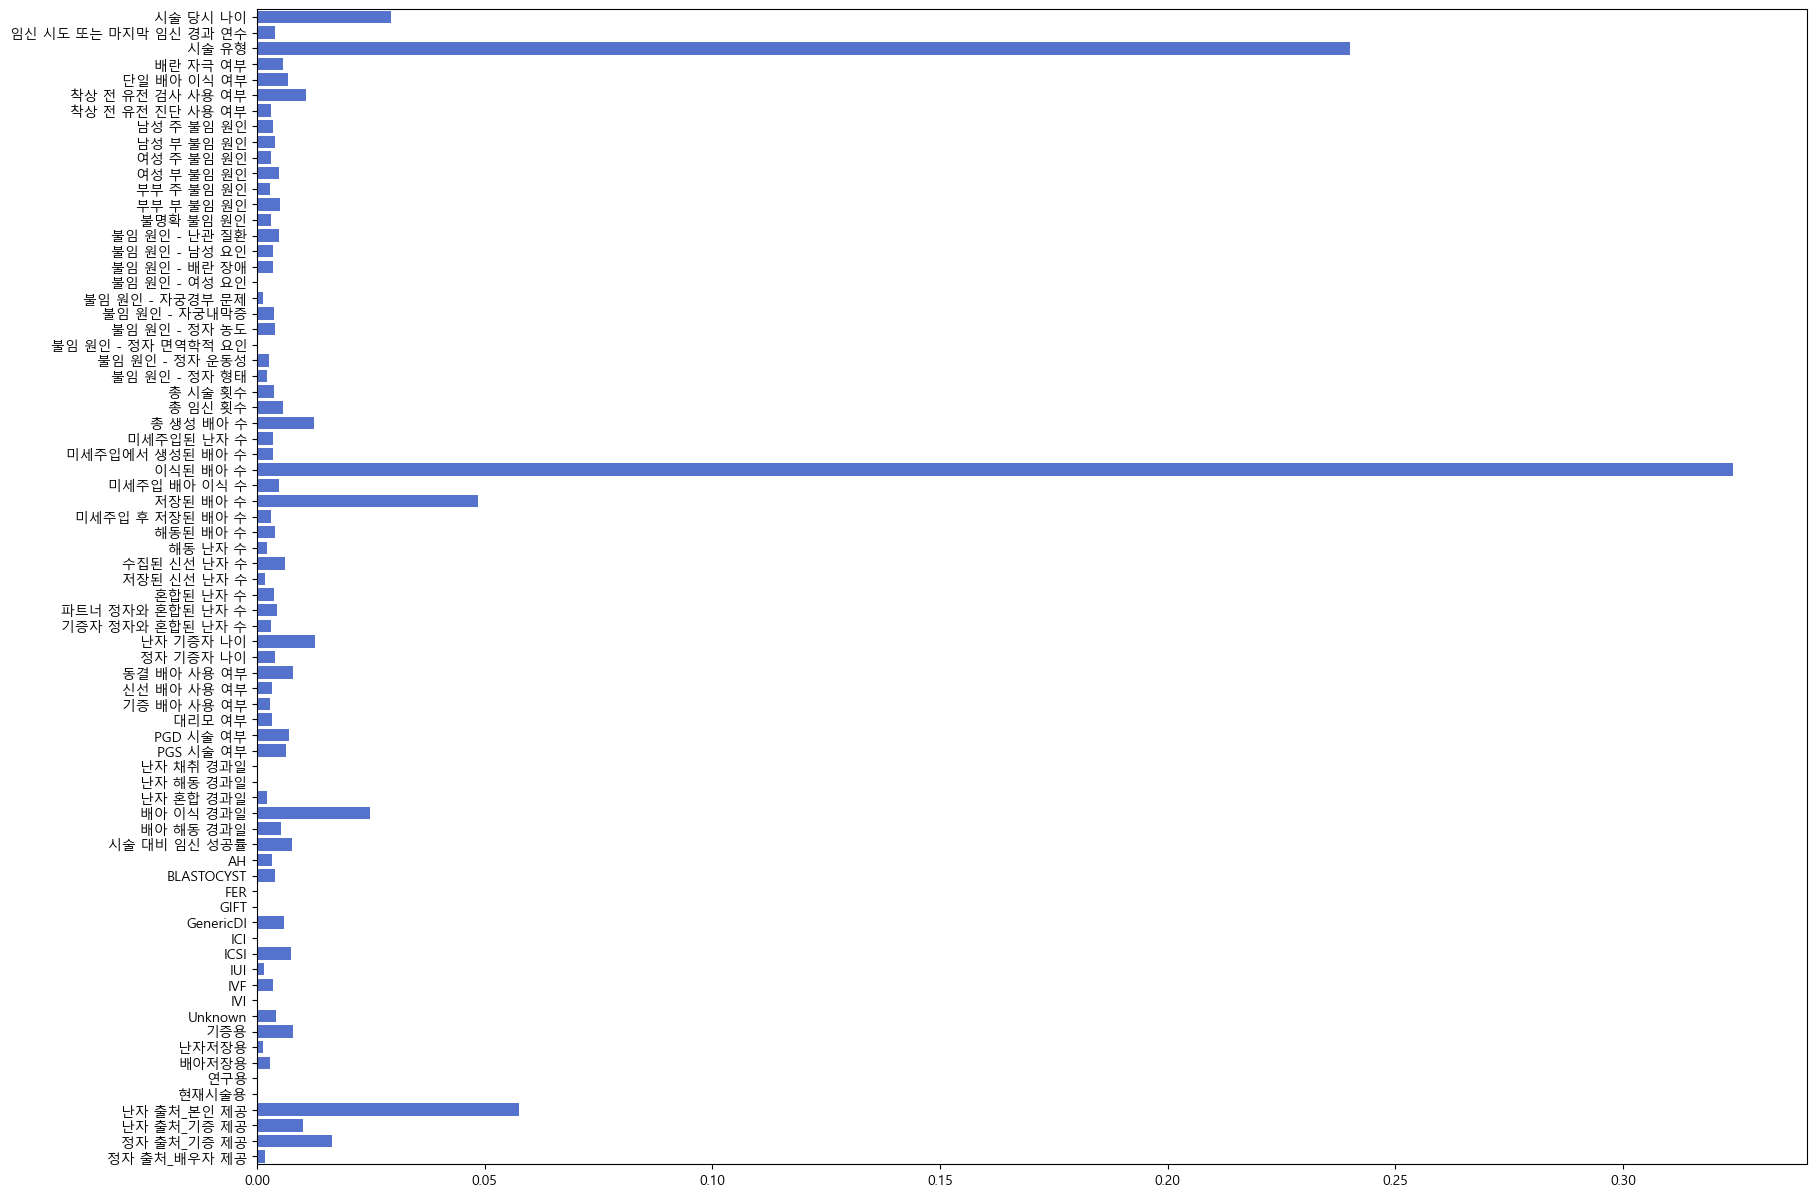

In [140]:
feature_names = X.columns.tolist()
plt.figure(figsize=(20,15))
if isinstance(model, LogisticRegression):
    sns.barplot(x=model.coef_[0], y=feature_names, palette=[ROYALBLUE])
else:
    sns.barplot(x=model.feature_importances_, y=feature_names, palette=[ROYALBLUE])

### 2. DESC Feature Importances

In [141]:
importances = (
    sorted(enumerate(model.coef_[0]), key=lambda x: x[1], reverse=True)[:5]
    if isinstance(model, LogisticRegression)
    else sorted(enumerate(model.feature_importances_), key=lambda x: x[1], reverse=True)[:5]
)

for idx, (col, score) in enumerate(importances, 1):
    print(f"{idx}. {X.columns.tolist()[col]} ({score:.2f})")

1. 이식된 배아 수 (0.32)
2. 시술 유형 (0.24)
3. 난자 출처_본인 제공 (0.06)
4. 저장된 배아 수 (0.05)
5. 시술 당시 나이 (0.03)


In [142]:
set(X.columns) - set(X_test.columns)

{'FER', 'GIFT', '연구용'}

# Create Submission

In [143]:
# Final Submission
model.fit(X, y)
prediction = model.predict(X_test)
df_submission = pd.DataFrame({'ID': df_test['ID'], 'probability': prediction})
df_submission.to_csv("submission.csv", index=False)
df_submission['probability'].value_counts()

ValueError: feature_names mismatch: ['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 여성 요인', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '총 시술 횟수', '총 임신 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 해동 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '시술 대비 임신 성공률', 'AH', 'BLASTOCYST', 'FER', 'GIFT', 'GenericDI', 'ICI', 'ICSI', 'IUI', 'IVF', 'IVI', 'Unknown', '기증용', '난자저장용', '배아저장용', '연구용', '현재시술용', '난자 출처_본인 제공', '난자 출처_기증 제공', '정자 출처_기증 제공', '정자 출처_배우자 제공'] ['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 여성 요인', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '총 시술 횟수', '총 임신 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 해동 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '시술 대비 임신 성공률', 'AH', 'BLASTOCYST', 'GenericDI', 'ICI', 'ICSI', 'IUI', 'IVF', 'IVI', 'Unknown', '기증용', '난자저장용', '배아저장용', '현재시술용', '난자 출처_본인 제공', '난자 출처_기증 제공', '정자 출처_기증 제공', '정자 출처_배우자 제공']
expected GIFT, FER, 연구용 in input data